Chargement du dataset ML final...
Dataset complet chargé. Shape: (836126, 29)
Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...
Dataset financier filtré. Nouvelle Shape: (20817, 29)
Définition des features pour le Modèle B (Financier uniquement)...
Features (X) sélectionnées: ['ratio_rentabilite_nette', 'ratio_endettement', 'ratio_marge_brute', 'ratio_capitaux_propres', 'ratio_tresorerie', 'ratio_resultat_financier', 'ratio_resultat_exceptionnel']
Target (y) sélectionnée: is_failed_in_3y
NOUVEAU Ratio de déséquilibre (sur 26k lignes): 506.73
Entraînement du Modèle B (Financier)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle B...
---
--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE') ---
Score ROC-AUC (Financier): 0.4737
---
Rapport de Classification (Financier):
               precision    recall  f1-score   support

Survivant (0)       1.00      0.98      0.99      4156
 Faillite (1)       0.00      0.00      0.00         8

     accuracy                           0.98      4164
    macro avg       0.50      0.49      0.50      4164
 weighted avg       1.00      0.98      0.99      4164

---
Matrice de Confusion (Financier):


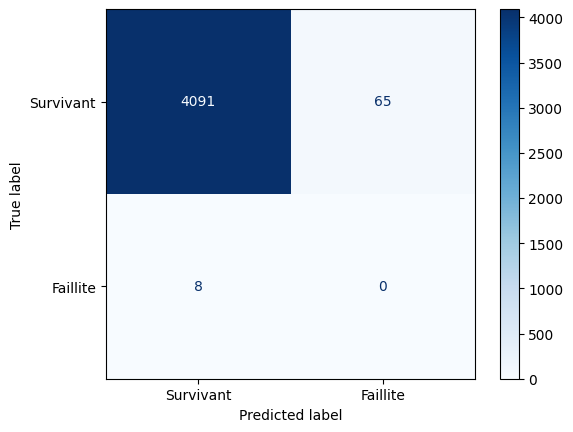

In [2]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER LE DATASET ML FINAL ---
print("Chargement du dataset ML final...")
try:
    df_full = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset complet chargé. Shape: {df_full.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

# ▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
# --- 1.5. LE FILTRE "EXPERT" (LA CORRECTION) ---
# ON NE GARDE QUE LES ENTREPRISES QUI ONT UN BILAN (les 26k)
# C'est la base de ce "Modèle B"
print("Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...")

# On utilise le même filtre que pour l'EDA :
df_final_ml = df_full.filter(
    pl.col("ratio_rentabilite_nette") != 0 
    # (ou un autre ratio, du moment qu'on exclut les 810k lignes de zéros)
)
print(f"Dataset financier filtré. Nouvelle Shape: {df_final_ml.shape}")
# ▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 2) ---
print("Définition des features pour le Modèle B (Financier uniquement)...")
FINANCIAL_FEATURES = [
    "ratio_rentabilite_nette", 
    "ratio_endettement", 
    "ratio_marge_brute", 
    "ratio_capitaux_propres",
    "ratio_tresorerie",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
]
TARGET = "is_failed_in_3y"

# On convertit en Pandas pour Scikit-Learn
X = df_final_ml.select(FINANCIAL_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {X.columns.to_list()}")
print(f"Target (y) sélectionnée: {y.name}")

# --- 3. GESTION DU DÉSÉQUILIBRE ---
# ▼▼▼ ON RECALCULE LE RATIO SUR LE NOUVEAU DATASET ▼▼▼
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"NOUVEAU Ratio de déséquilibre (sur 26k lignes): {scale_pos_weight:.2f}")
# ▲▲▲ LE RATIO VA CHANGER, C'EST NORMAL ▲▲▲

# --- 4. PRÉPARATION (Preprocessing) ---
# (Rien ne change ici)
numerical_features = FINANCIAL_FEATURES
numerical_transformer = StandardScaler() 

preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, numerical_features)],
    remainder="passthrough"
)

# --- 5. SPLIT (Train / Test) ---
# (Rien ne change ici)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
# (Rien ne change ici)
model_B = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# --- 7. ENTRAÎNEMENT (Itération 2) ---
print("Entraînement du Modèle B (Financier)...")
model_B.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Moteur") ---
# (Rien ne change ici)
print("Évaluation du Modèle B...")
y_pred = model_B.predict(X_test)
y_pred_proba = model_B.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE') ---")
print(f"Score ROC-AUC (Financier): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Financier):")
print(report)
print("---")

print("Matrice de Confusion (Financier):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Chargement du dataset ML final...
Dataset complet chargé. Shape: (836126, 29)
Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...
Dataset financier filtré. Nouvelle Shape: (20817, 29)
Définition des features pour le Modèle B (Financier uniquement)...
Features (X) sélectionnées: ['ratio_rentabilite_nette', 'ratio_endettement', 'ratio_marge_brute', 'ratio_capitaux_propres', 'ratio_tresorerie', 'ratio_resultat_financier', 'ratio_resultat_exceptionnel']
Target (y) sélectionnée: is_failed_in_3y
NOUVEAU Ratio de déséquilibre (sur 26k lignes): 506.73
Preprocessing avec ROBUST Scaler (pour gérer les outliers)...
Entraînement du Modèle B (Financier)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle B...
---
--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE') ---
Score ROC-AUC (Financier): 0.6220
---
Rapport de Classification (Financier):
               precision    recall  f1-score   support

Survivant (0)       1.00      1.00      1.00      4156
 Faillite (1)       0.00      0.00      0.00         8

     accuracy                           1.00      4164
    macro avg       0.50      0.50      0.50      4164
 weighted avg       1.00      1.00      1.00      4164

---
Matrice de Confusion (Financier):


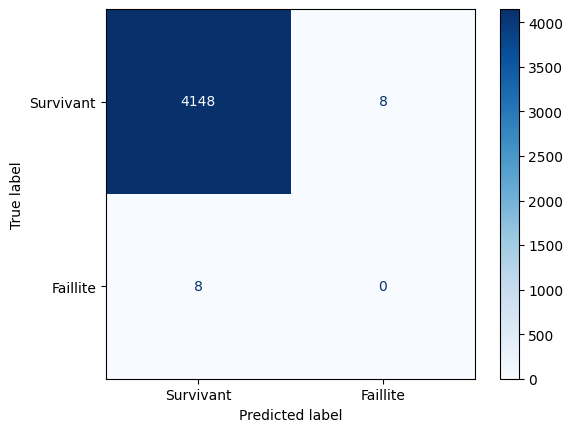

In [4]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ▼▼▼ ON CHANGE LE PREPROCESSOR ▼▼▼
from sklearn.preprocessing import RobustScaler  # On importe le bon scaler
# ▲▲▲ ON CHANGE LE PREPROCESSOR ▲▲▲
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER ET FILTRER LE DATASET ---
print("Chargement du dataset ML final...")
try:
    df_full = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset complet chargé. Shape: {df_full.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

print("Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...")
df_final_ml = df_full.filter(
    pl.col("ratio_rentabilite_nette") != 0 
)
print(f"Dataset financier filtré. Nouvelle Shape: {df_final_ml.shape}")

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 2) ---
print("Définition des features pour le Modèle B (Financier uniquement)...")
FINANCIAL_FEATURES = [
    "ratio_rentabilite_nette", 
    "ratio_endettement", 
    "ratio_marge_brute", 
    "ratio_capitaux_propres",
    "ratio_tresorerie",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
]
TARGET = "is_failed_in_3y"

X = df_final_ml.select(FINANCIAL_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {X.columns.to_list()}")
print(f"Target (y) sélectionnée: {y.name}")

# --- 3. GESTION DU DÉSÉQUILIBRE ---
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"NOUVEAU Ratio de déséquilibre (sur 26k lignes): {scale_pos_weight:.2f}")

# --- 4. PRÉPARATION (Preprocessing) ---
# ▼▼▼ ON CHANGE LE PREPROCESSING ▼▼▼
print("Preprocessing avec ROBUST Scaler (pour gérer les outliers)...")
numerical_features = FINANCIAL_FEATURES
numerical_transformer = RobustScaler() # On utilise RobustScaler

preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, numerical_features)],
    remainder="passthrough"
)
# ▲▲▲ ON CHANGE LE PREPROCESSING ▲▲▲

# --- 5. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
model_B = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# --- 7. ENTRAÎNEMENT (Itération 2) ---
print("Entraînement du Modèle B (Financier)...")
model_B.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Moteur") ---
print("Évaluation du Modèle B...")
y_pred = model_B.predict(X_test)
y_pred_proba = model_B.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE') ---")
print(f"Score ROC-AUC (Financier): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Financier):")
print(report)
print("---")

print("Matrice de Confusion (Financier):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Chargement du dataset ML final...
Dataset complet chargé. Shape: (836126, 29)
Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...
Dataset financier filtré. Nouvelle Shape: (20817, 29)
Définition des features pour le Modèle B (Financier uniquement)...
NOUVEAU Ratio de déséquilibre: 506.73
Preprocessing: Clipping des outliers (valeurs > 5 et < -5)...
Création de la pipeline (XGBoost seul)...
Entraînement du Modèle B (Financier - Clipped)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:36:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle B...
---
--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE - CLIPPED') ---
Score ROC-AUC (Financier): 0.6404
---
Rapport de Classification (Financier):
               precision    recall  f1-score   support

Survivant (0)       1.00      1.00      1.00      4156
 Faillite (1)       0.00      0.00      0.00         8

     accuracy                           0.99      4164
    macro avg       0.50      0.50      0.50      4164
 weighted avg       1.00      0.99      1.00      4164

---
Matrice de Confusion (Financier):


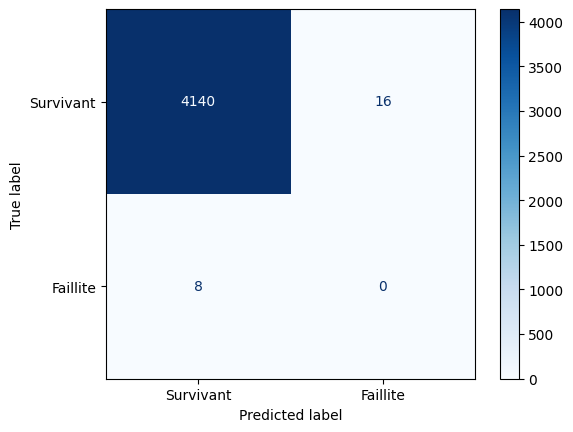

In [5]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ▼▼▼ ON N'A PLUS BESOIN DE SCALER ▼▼▼
# from sklearn.preprocessing import RobustScaler 
# from sklearn.compose import ColumnTransformer
# ▲▲▲ ON N'A PLUS BESOIN DE SCALER ▲▲▲
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER ET FILTRER LE DATASET ---
print("Chargement du dataset ML final...")
try:
    df_full = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset complet chargé. Shape: {df_full.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

print("Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...")
df_final_ml = df_full.filter(
    pl.col("ratio_rentabilite_nette") != 0 
)
print(f"Dataset financier filtré. Nouvelle Shape: {df_final_ml.shape}")

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 2) ---
print("Définition des features pour le Modèle B (Financier uniquement)...")
FINANCIAL_FEATURES = [
    "ratio_rentabilite_nette", 
    "ratio_endettement", 
    "ratio_marge_brute", 
    "ratio_capitaux_propres",
    "ratio_tresorerie",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
]
TARGET = "is_failed_in_3y"

X_pl = df_final_ml.select(FINANCIAL_FEATURES)
y_pl = df_final_ml.select(TARGET)

# --- 3. GESTION DU DÉSÉQUILIBRE ---
scale_pos_weight = y_pl.to_pandas().squeeze().value_counts()[0] / y_pl.to_pandas().squeeze().value_counts()[1]
print(f"NOUVEAU Ratio de déséquilibre: {scale_pos_weight:.2f}")

# --- 4. NOUVEAU PREPROCESSING (LE "CLIPPING") ---
# ▼▼▼ ON "COUPE" LES VALEURS EXTRÊMES ▼▼▼
print("Preprocessing: Clipping des outliers (valeurs > 5 et < -5)...")

# On définit nos bornes (ex: -500% et +500%)
LOWER_BOUND = -5.0
UPPER_BOUND = 5.0

# On "clippe" les ratios
X_clipped = X_pl.with_columns(
    pl.col(FINANCIAL_FEATURES).clip(lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND)
)

# On convertit en Pandas APRES le clipping
X = X_clipped.to_pandas()
y = y_pl.to_pandas().squeeze()
# ▲▲▲ FIN DU CLIPPING ▲▲▲

# --- 5. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
# ▼▼▼ PIPELINE SIMPLIFIÉE (SANS PREPROCESSOR) ▼▼▼
print("Création de la pipeline (XGBoost seul)...")
model_B = XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    )
# ▲▲▲ PIPELINE SIMPLIFIÉE ▲▲▲

# --- 7. ENTRAÎNEMENT (Itération 3) ---
print("Entraînement du Modèle B (Financier - Clipped)...")
model_B.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Moteur") ---
print("Évaluation du Modèle B...")
y_pred = model_B.predict(X_test)
y_pred_proba = model_B.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE - CLIPPED') ---")
print(f"Score ROC-AUC (Financier): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Financier):")
print(report)
print("---")

print("Matrice de Confusion (Financier):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [6]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ▼▼▼ ON IMPORTE SMOTE ET LA PIPELINE IMBLEARN ▼▼▼
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
# ▲▲▲ ON IMPORTE SMOTE ▲▲▲
from sklearn.preprocessing import RobustScaler # On garde RobustScaler, c'est une bonne pratique
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER ET FILTRER LE DATASET ---
print("Chargement du dataset ML final...")
try:
    df_full = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset complet chargé. Shape: {df_full.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

print("Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...")
df_final_ml = df_full.filter(
    pl.col("ratio_rentabilite_nette") != 0 
)
print(f"Dataset financier filtré. Nouvelle Shape: {df_final_ml.shape}")

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 2) ---
print("Définition des features pour le Modèle B (Financier uniquement)...")
FINANCIAL_FEATURES = [
    "ratio_rentabilite_nette", 
    "ratio_endettement", 
    "ratio_marge_brute", 
    "ratio_capitaux_propres",
    "ratio_tresorerie",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
]
TARGET = "is_failed_in_3y"

X = df_final_ml.select(FINANCIAL_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

# --- 3. PRÉPARATION (Preprocessing) ---
# On garde le RobustScaler, il gère les outliers avant de les donner à SMOTE
print("Preprocessing avec ROBUST Scaler (pour gérer les outliers)...")
numerical_features = FINANCIAL_FEATURES
numerical_transformer = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, numerical_features)],
    remainder="passthrough"
)

# --- 4. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Taille du Test set: {X_test.shape[0]}. Nb Faillites dans le Test set: {y_test.sum()}")

# --- 5. CRÉATION DE LA PIPELINE "MONSTRUEUSE" (AVEC SMOTE) ---
# ▼▼▼ ON CHANGE LA PIPELINE ▼▼▼
print("Création de la pipeline (RobustScaler + SMOTE + XGBoost)...")
model_B = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    
    # ÉTAPE 2: SMOTE
    # Crée des faillites synthétiques UNIQUEMENT sur le X_train
    ('smote', SMOTE(random_state=42)), 
    
    # ÉTAPE 3: CLASSIFIER
    ('classifier', XGBClassifier(
        # On n'a plus besoin de scale_pos_weight, SMOTE a fait le boulot
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])
# ▲▲▲ ON CHANGE LA PIPELINE ▲▲▲

# --- 7. ENTRAÎNEMENT (Itération 4) ---
print("Entraînement du Modèle B (Financier - SMOTE)...")
model_B.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Moteur") ---
print("Évaluation du Modèle B...")
y_pred = model_B.predict(X_test)
y_pred_proba = model_B.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE - SMOTE') ---")
print(f"Score ROC-AUC (Financier): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Financier):")
print(report)
print("---")

print("Matrice de Confusion (Financier):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

ModuleNotFoundError: No module named 'imblearn'